In [1]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.append("..")
import shutil
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt
import flopy
import pyemu

## Monte Carlo with Freyberg Pilot Points Model

### This is essentially the same work flow as ``freyberg_kr`` and ``freyberg_zone`` monte carlo notebooks - again, the power of scripting!


## Using `pyemu`

In [2]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP


['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_pilot_points_monte_carlo/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. 

In [3]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [4]:
mc = pyemu.MonteCarlo(pst=pst,verbose=False)

### Important: since we didn't pass a ``parcov`` arg to ``MonteCarlo``, that means the prior parameter covariance matrix was constructed from the parameter bounds (it does NOT include spatial correlation information for the pilot points - remember all the geostatics?)

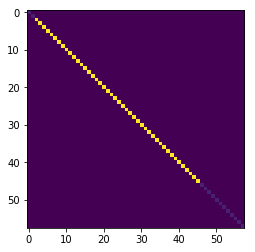

In [5]:
plt.imshow(mc.parcov.as_2d)

### ```draw```

In [26]:
mc.draw(num_reals=500)
print(mc.parensemble.shape)
print(mc.parensemble.mean().head())

(500, 58)
parnme
rch_0    1.064060
rch_1    1.076072
hk00     9.442918
hk01     9.071351
hk02     9.517570
dtype: float64


## plotting

### Since ```ParameterEnsemble``` is dervied from ```pandas.DataFrame```, it has all the cool methods and attributes we all love.  Let's compare the results of drawing from a uniform vs a gaussian distribution.  This may take some time.

In [27]:
mc.parensemble.columns

Index(['rch_0', 'rch_1', 'hk00', 'hk01', 'hk02', 'hk03', 'hk04', 'hk05',
       'hk06', 'hk07', 'hk08', 'hk09', 'hk10', 'hk11', 'hk12', 'hk13', 'hk14',
       'hk15', 'hk16', 'hk17', 'hk18', 'hk19', 'hk20', 'hk21', 'hk22', 'hk23',
       'hk24', 'hk25', 'hk26', 'hk27', 'hk28', 'hk29', 'hk30', 'hk31', 'hk32',
       'hk33', 'hk34', 'hk35', 'hk36', 'hk37', 'hk38', 'hk39', 'hk40', 'hk41',
       'hk42', 'hk43', 'w0_r09_c16', 'w0_r11_c13', 'w0_r20_c14', 'w0_r26_c10',
       'w0_r29_c06', 'w0_r34_c12', 'w1_r09_c16', 'w1_r11_c13', 'w1_r20_c14',
       'w1_r26_c10', 'w1_r29_c06', 'w1_r34_c12'],
      dtype='object', name='parnme')

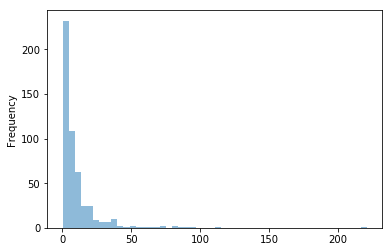

In [9]:
ax = plt.subplot(111)
partoplot = 'hk10'
mc.parensemble.loc[:,partoplot].plot(kind="hist",bins=50,ax=ax,alpha=0.5)

In [10]:
def plot_first_10_reals(paren):
    arrs = []
    pp_df = pyemu.gw_utils.pp_tpl_to_dataframe(os.path.join(working_dir,"hkpp.dat.tpl"))
    pp_df.loc[:,"iidx"] = pp_df.index
    for real in paren.index.values[:10]:
        pp_df.index = pp_df.parnme
        pp_df.loc[:,"parval1"] = paren.loc[real,pp_df.parnme].T
        pp_df.index = pp_df.iidx
        arr = pyemu.utils.gw_utils.fac2real(pp_df,os.path.join(working_dir,"hkpp.dat.fac"))
        arrs.append(np.log10(np.loadtxt(arr)))
    mx,mn = -1.0E+10,1.0e+10
    for arr in arrs:
        mx = max(mx,arr.max())
        mn = min(mn,arr.min())
    fig = plt.figure(figsize=(10,10))
    m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
    for i,arr in enumerate(arrs):
        ax = plt.subplot(2,5,i+1,aspect="equal")
        m.upw.hk[0] = arr
        m.upw.hk[0].plot(axes=[ax],alpha=0.5)
        ax.scatter(pp_df.x,pp_df.y,marker='.',color='k',s=4)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.show()
    
    

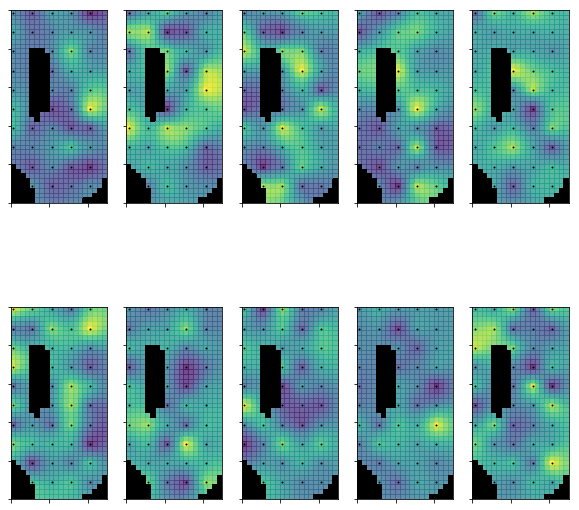

In [11]:
plot_first_10_reals(mc.parensemble)

### Do these look "right" (from a geologic stand point)? Lots of "random" variation (pilot points spatially near each other can have very different values)...not much structure...why?

### Let's use a full covariance matrix and see how that looks

,rch_0,rch_1,hk00,hk01,hk02,hk03,hk04,hk05,hk06,hk07,...,w0_r20_c14,w0_r26_c10,w0_r29_c06,w0_r34_c12,w1_r09_c16,w1_r11_c13,w1_r20_c14,w1_r26_c10,w1_r29_c06,w1_r34_c12
rch_0,0.022655,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rch_1,0.000000,0.022655,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hk00,0.000000,0.000000,0.250000,0.16758,0.112332,0.075299,0.050474,0.167580,0.141993,0.102210,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hk01,0.000000,0.000000,0.167580,0.25000,0.167580,0.112332,0.075299,0.141993,0.167580,0.141993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hk02,0.000000,0.000000,0.112332,0.16758,0.250000,0.167580,0.112332,0.102210,0.141993,0.167580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


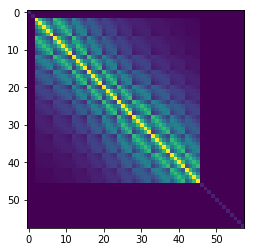

In [12]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500,anisotropy=1.0,bearing=0.0)
gs = pyemu.utils.geostats.GeoStruct(variograms=[v])
pp_tpl = os.path.join(working_dir,"hkpp.dat.tpl")
cov = pyemu.helpers.geostatistical_prior_builder(pst=mc.pst,struct_dict={gs:pp_tpl})
plt.imshow(cov.x,interpolation="nearest")
cov.to_dataframe().head()

In [13]:
mc_full = pyemu.MonteCarlo(pst=pst,parcov=cov)

In [14]:
mc_full.draw(500)

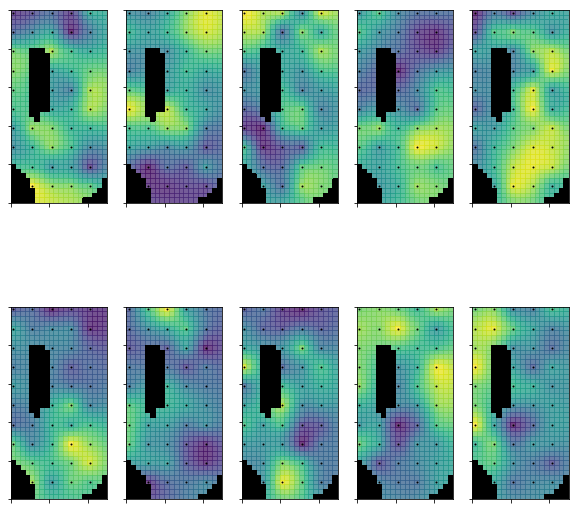

In [15]:
plot_first_10_reals(mc_full.parensemble)

### Much better! now let's run the parameter ensemble through the model using sweep

In [16]:
mc_full.parensemble.to_csv(os.path.join(working_dir,"sweep_in.csv"))

### Remember, this is going to give your machine a work out....watch what is going on the terminal and wait for the "*" to become a number

In [17]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"sweep",pst_name,num_slaves=15,master_dir='.')
os.chdir("..")

master:./sweep freyberg_pp.pst /h :4004 in .
slave:./sweep freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:./sweep freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:./sweep freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:./sweep freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:./sweep freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:./sweep freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:./sweep freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:./sweep freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:./sweep freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:./sweep freyberg_pp.pst /h localhost:4004 in ../slave_9
slave:./sweep freyberg_pp.pst /h localhost:4004 in ../slave_10
slave:./sweep freyberg_pp.pst /h localhost:4004 in ../slave_11
slave:./sweep freyberg_pp.pst /h localhost:4004 in ../slave_12
slave:./sweep freyberg_pp.pst /h localhost:4004 in ../slave_13
slave:./sweep freyberg_pp.pst /h localhost:4004 in ../slave_14


In [18]:
df_out = pd.read_csv(os.path.join(working_dir,"sweep_out.csv"),index_col=0)
df_out.columns = [c.lower() for c in df_out.columns]

In [19]:

df_out = df_out.loc[df_out.failed_flag==0,:] #drop an failed runs
df_out.head()

,input_run_id,failed_flag,phi,meas_phi,regul_phi,vol_percent,flx_wells,flx_river_l,foretrav,flx_storage,...,vol_total_19750101,vol_wells_19750101,vol_constan_19750102,vol_in-out_19750102,vol_percent_19750102,vol_recharg_19750102,vol_river_l_19750102,vol_storage_19750102,vol_total_19750102,vol_wells_19750102
run_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,3464.017147,3464.017147,0,0,0,0,0,0,...,1339.0,-7107607.00,1.119772e+06,1340.0,0.01,7377585.0,-1407271.250,21434.859375,1340.0,-7110181.50
1,1,0,6294.228877,6294.228877,0,0,0,0,0,0,...,5867.0,-5282960.50,-1.021630e+05,5867.0,0.08,4947991.5,247955.875,198235.328125,5867.0,-5286152.50
2,2,0,97156.545708,97156.545708,0,0,0,0,0,0,...,122.5,-4178206.75,-2.505235e+05,123.0,0.00,6848465.5,-3003440.000,585757.500000,123.0,-4180136.75
3,3,0,8658.858069,8658.858069,0,0,0,0,0,0,...,22.0,-3400322.25,8.705446e+05,24.0,0.00,10131409.0,-7626472.000,28006.894531,24.0,-3403465.50
4,4,0,3618.346622,3618.346622,0,0,0,0,0,0,...,932.0,-5056831.00,8.026579e+05,931.0,0.01,6556212.0,-2325317.750,26433.021484,931.0,-5059054.00


### So now we need to specify our "good enough" threshold.  Look back at your ``freyberg_pilot_points_2\freyberg_pilot_points_setup`` notebook and use a value slightly larger than your ``phimlim`` value...makes sense right?  We should expect "good enough" realizations to atleast be in the ball park of the target objective function....

In [20]:
acceptable_phi = 550.0
good_enough = df_out.loc[df_out.phi<acceptable_phi].index.values
print(good_enough)

[124]


# Oh crap! what happened?

In [21]:
df_out.phi.min()

655.23126295042198

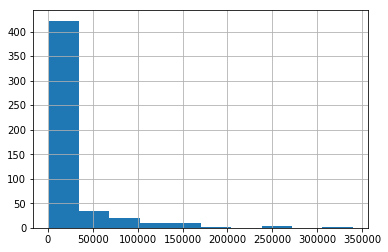

In [22]:
df_out.phi.hist()

### Here is a major problem with "rejection sampling" in high dimensions: you have to run the model many many many many many times to find even a few realizations that fit the data acceptably well.  

### With all these parameters, there are so many possible combinations, that very few realizations fit the data very well...we will address this problem later, so for now, let bump our "good enough" threshold to some realizations to plot:

In [28]:
acceptable_phi = 1500.0
good_enough = df_out.loc[df_out.phi<acceptable_phi].index.values
print(good_enough)

[ 17  41  76 102 124 175 193 207 259 293 367 377 397 444 448]


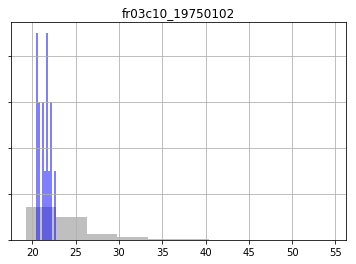

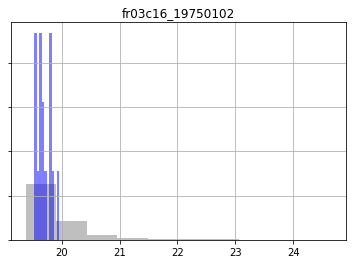

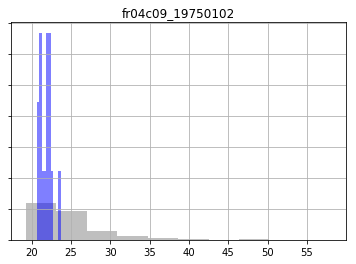

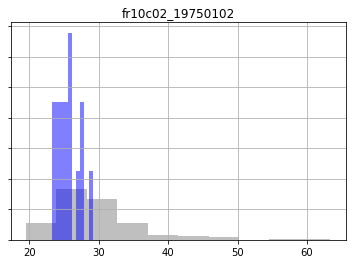

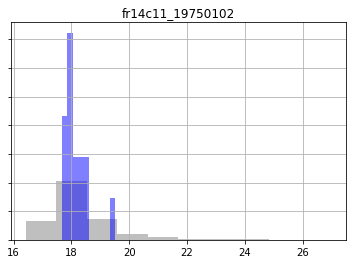

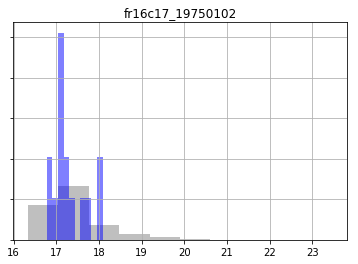

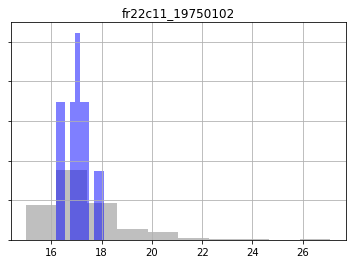

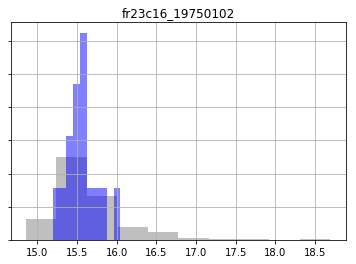

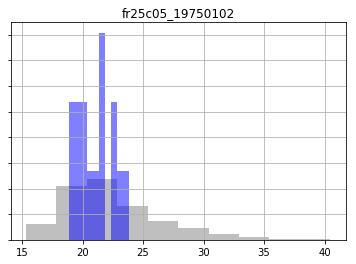

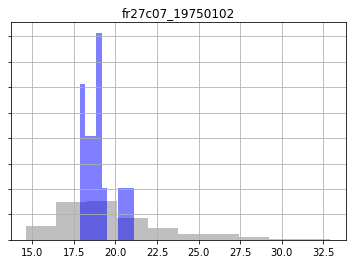

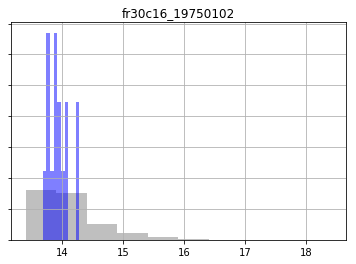

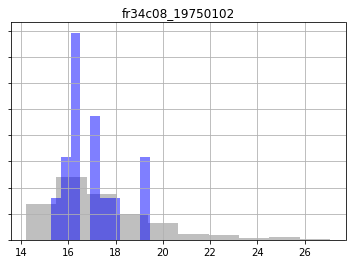

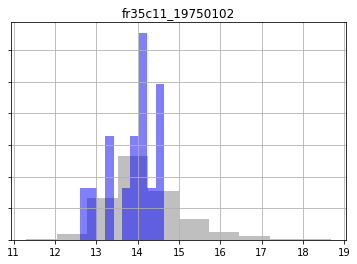

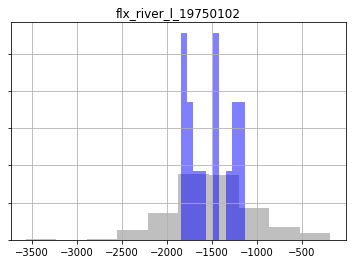

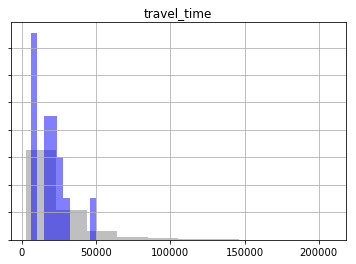

In [29]:
for forecast in mc.pst.forecast_names:
    ax = df_out.loc[:,forecast].hist(alpha=0.5,color='0.5',normed=True)
    ax.set_yticklabels([])
    df_out.loc[good_enough,forecast].hist(ax=ax,alpha=0.5,color='b',normed=True)
    ax.set_title(forecast)   
    plt.show()
    

### Interesting results!!! We see that for the river flux and travel time forecasts, the posterior uncertainty is very similar to the prior...that means "calibration" hasn't helped us learn about these forecasts...

### As before, let's now use our knowledge of the "truth" to see how we are doing...

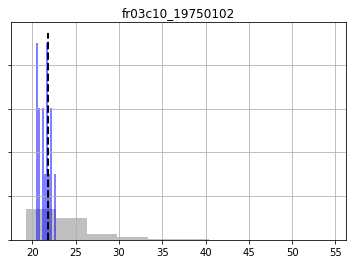

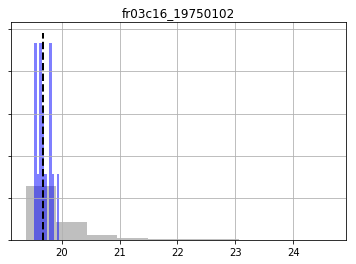

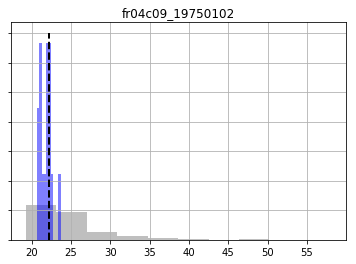

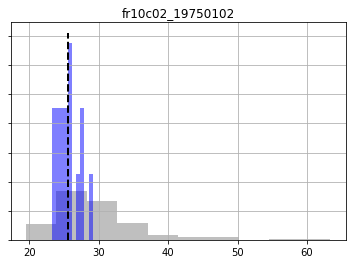

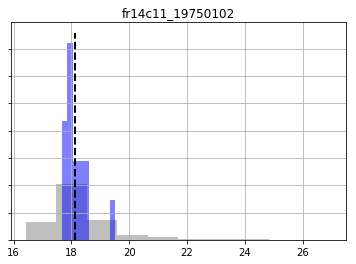

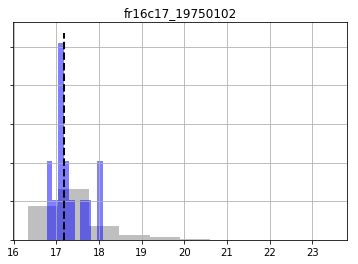

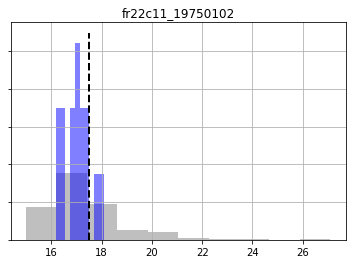

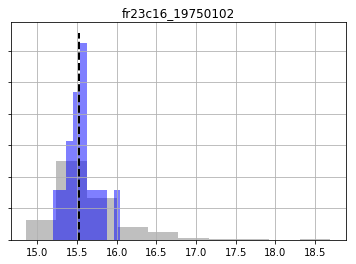

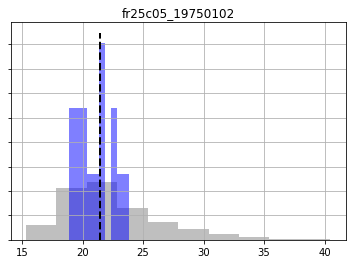

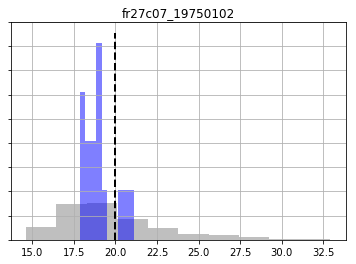

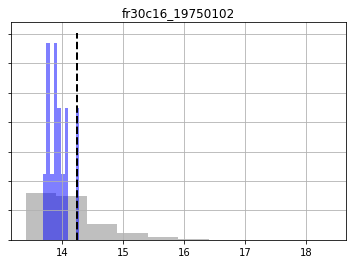

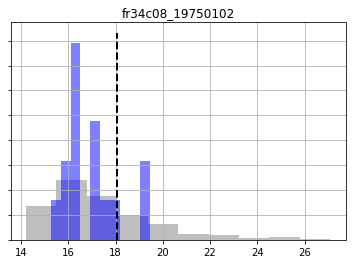

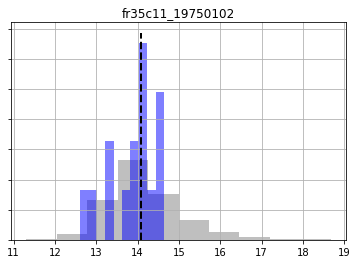

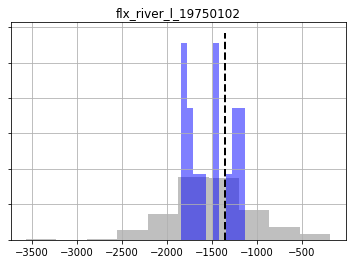

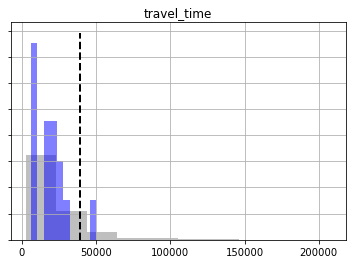

In [30]:
for forecast in mc.pst.forecast_names:
    ax = df_out.loc[:,forecast].hist(alpha=0.5,color='0.5',normed=True)
    ax.set_yticklabels([])
    df_out.loc[good_enough,forecast].hist(ax=ax,alpha=0.5,color='b',normed=True)
    ax.set_title(forecast)   
    ylim = ax.get_ylim()
    v = mc.pst.observation_data.loc[forecast,"obsval"]
    ax.plot([v,v],ylim,"k--",lw=2.0)
    ax.set_title(forecast)
    plt.show()

### Its hard to say how the posterior compares to the prior with so few "good enough" realizations.  To fix this problem, we have two choices:
### - run the model more times for Monte Carlo (!)
### - generate realizations that fix the data better before hand